In [228]:
import cv2
import os
import numpy as np
import pandas as pd
import pytesseract
from pytesseract import Output
import matplotlib.pyplot as plt
pytesseract.pytesseract.tesseract_cmd="/home/aman/anaconda3/envs/tallyInvoiceParser.env/bin/tesseract"
os.environ['TESSDATA_PREFIX'] = "/home/aman/anaconda3/envs/tallyInvoiceParser.env/share/tessdata"
os.environ['MLIR_CRASH_REPRODUCER_DIRECTORY']='tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269'
import import_ipynb
from imagePreProcessor import *
import math
from sklearn.model_selection import train_test_split
import keras
from keras import models
from keras.models import Sequential
from keras.layers import Dense, ReLU, activation, Dropout
import tensorflow as tf
import datefinder
import dateparser

In [229]:
pwd

'/home/aman/Documents/Tally/Git-Document-AI/Document-AI/InvoiceDateModel/Dataset'

In [230]:
os.chdir('/home/aman/Documents/Tally/Git-Document-AI/Document-AI/InvoiceDateModel/Dataset/')

In [231]:
df = pd.read_csv("tesseract.csv")

In [232]:
df.drop_duplicates(subset=["x", "y", "imageName"], keep="first", inplace=True)

In [233]:
df.shape

(116, 30)

In [234]:
df.describe()

,Unnamed: 0,left,top,width,height,conf,x,y,PageHeight,PageWidth,...,invoice,delivery,order,due,payment,tax,bill,receipt,issue,output
count,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,...,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000
mean,77.896552,734.663793,774.413793,183.137931,26.172414,73.244131,913.594828,802.965517,2367.310345,1787.077586,...,0.114257,0.019891,0.032606,0.006202,0.024921,0.077284,0.024885,0.005784,0.005288,0.431034
std,45.198188,507.927895,583.415790,142.760298,10.860600,26.550087,516.614682,582.544761,419.772929,254.771719,...,0.162987,0.079340,0.135460,0.038796,0.082323,0.170594,0.082962,0.035994,0.028984,0.497369
min,0.000000,9.000000,44.000000,66.000000,13.000000,0.000000,107.000000,65.000000,319.000000,1653.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,38.750000,275.750000,353.750000,113.000000,20.000000,64.169218,429.500000,376.000000,2200.000000,1654.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,78.000000,654.500000,533.500000,134.000000,23.000000,82.692742,842.000000,572.500000,2339.000000,1670.000000,...,0.055845,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,118.250000,1213.750000,1047.000000,178.000000,27.000000,92.788505,1391.750000,1082.750000,2339.000000,1700.000000,...,0.159477,0.000000,0.000000,0.000000,0.000000,0.033302,0.000000,0.000000,0.000000,1.000000
max,153.000000,2043.000000,2876.000000,1029.000000,76.000000,96.851837,2167.000000,2906.000000,3312.000000,2342.000000,...,0.854212,0.641643,0.863594,0.283237,0.666771,0.744913,0.757865,0.252860,0.201084,1.000000


In [235]:
len(df["imageName"].unique())

44

In [236]:
def preProcess(df):
    for index in df.index:
        
        x = df["x"][index]
        y = df["y"][index]
        X = df["PageWidth"][index]
        X = X/2
        Y = df["PageHeight"][index]
        Y = Y/2
        
        text = df["text"][index]
        date = list(datefinder.find_dates(text))[0]
        
        if x<X:
            df["isLeft"][index]=1
        elif x>=X:
            df["isRight"][index]=1
            
        if y<Y:
            df["isBottom"][index]=1
        elif y>Y:
            df["isTop"][index]=1
            
        
            
    df["x"]/=df["PageWidth"]
    df["y"]/=df["PageHeight"]
    
    colsToDrop = ["Unnamed: 0", "left", "top", "width", "height", "imageName", "text", "PageHeight", "PageWidth", "conf", "isPast", "isFuture"]
    df.drop(columns=colsToDrop, inplace=True)
    

In [237]:
preProcess(df)

/tmp/ipykernel_9820/413941093.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["isLeft"][index]=1
/tmp/ipykernel_9820/413941093.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["isBottom"][index]=1
/tmp/ipykernel_9820/413941093.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["isRight"][index]=1
/tmp/ipykernel_9820/413941093.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

In [238]:
df

,x,y,isTop,isBottom,isRight,isLeft,date,dated,invoice,delivery,order,due,payment,tax,bill,receipt,issue,output
0,0.275091,0.482257,0,1,0,1,0.541396,0.0,0.494869,0.0,0.151753,0.000000,0.000000,0.528837,0.0,0.0,0.0,0
1,0.927449,0.499786,0,1,1,0,0.111245,0.0,0.157799,0.0,0.804302,0.000000,0.000000,0.131721,0.0,0.0,0.0,1
2,0.591898,0.791364,1,0,1,0,0.120358,0.0,0.184538,0.0,0.000000,0.000000,0.162403,0.421051,0.0,0.0,0.0,0
3,0.591898,0.821719,1,0,1,0,0.116690,0.0,0.159205,0.0,0.000000,0.000000,0.132623,0.000000,0.0,0.0,0.0,0
4,0.906892,0.499786,0,1,1,0,0.090689,0.0,0.137243,0.0,0.783751,0.000000,0.000000,0.112152,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,0.878235,0.246818,0,1,1,0,0.000000,0.0,0.366004,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0
149,0.864706,0.198636,0,1,1,0,0.000000,0.0,0.347363,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1
151,0.512402,0.177426,0,1,1,0,0.081065,0.0,0.124913,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1
152,0.878403,0.471997,0,1,1,0,0.031390,0.0,0.423249,0.0,0.283171,0.021537,0.042880,0.000000,0.0,0.0,0.0,0


In [239]:
df.describe()

,x,y,isTop,isBottom,isRight,isLeft,date,dated,invoice,delivery,order,due,payment,tax,bill,receipt,issue,output
count,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000
mean,0.520881,0.346183,0.215517,0.784483,0.508621,0.491379,0.046758,0.003265,0.114257,0.019891,0.032606,0.006202,0.024921,0.077284,0.024885,0.005784,0.005288,0.431034
std,0.289285,0.261506,0.412965,0.412965,0.502095,0.502095,0.086447,0.015978,0.162987,0.079340,0.135460,0.038796,0.082323,0.170594,0.082962,0.035994,0.028984,0.497369
min,0.045766,0.019626,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.251554,0.170909,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.503175,0.252140,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.055845,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.834341,0.472179,0.000000,1.000000,1.000000,1.000000,0.076240,0.000000,0.159477,0.000000,0.000000,0.000000,0.000000,0.033302,0.000000,0.000000,0.000000,1.000000
max,0.927449,1.865204,1.000000,1.000000,1.000000,1.000000,0.541396,0.098908,0.854212,0.641643,0.863594,0.283237,0.666771,0.744913,0.757865,0.252860,0.201084,1.000000


In [240]:
df.corr()

,x,y,isTop,isBottom,isRight,isLeft,date,dated,invoice,delivery,order,due,payment,tax,bill,receipt,issue,output
x,1.000000,-0.249552,-0.316487,0.316487,0.918012,-0.918012,-0.092284,0.175339,0.370592,0.112641,0.270715,-0.046468,0.210537,-0.063955,0.056344,0.013197,-0.180816,0.188118
y,-0.249552,1.000000,0.771581,-0.771581,-0.188993,0.188993,-0.029214,-0.167995,-0.154547,0.045142,0.064125,-0.066959,0.036578,0.209129,-0.096545,0.273197,-0.139800,-0.337793
isTop,-0.316487,0.771581,1.000000,-1.000000,-0.281633,0.281633,-0.074201,-0.107570,-0.190098,-0.077297,-0.126711,-0.084154,-0.083894,0.313734,-0.121546,0.053823,-0.096041,-0.329199
isBottom,0.316487,-0.771581,-1.000000,1.000000,0.281633,-0.281633,0.074201,0.107570,0.190098,0.077297,0.126711,0.084154,0.083894,-0.313734,0.121546,-0.053823,0.096041,0.329199
isRight,0.918012,-0.188993,-0.281633,0.281633,1.000000,-1.000000,-0.092965,0.201722,0.322514,0.079952,0.207053,-0.094126,0.203701,-0.046036,0.022399,0.044793,-0.186421,0.159095
isLeft,-0.918012,0.188993,0.281633,-0.281633,-1.000000,1.000000,0.092965,-0.201722,-0.322514,-0.079952,-0.207053,0.094126,-0.203701,0.046036,-0.022399,-0.044793,0.186421,-0.159095
date,-0.092284,-0.029214,-0.074201,0.074201,-0.092965,0.092965,1.000000,-0.111488,0.239139,0.018789,0.080132,0.278948,-0.016205,0.211698,0.039165,-0.051972,0.178980,0.016510
dated,0.175339,-0.167995,-0.107570,0.107570,0.201722,-0.201722,-0.111488,1.000000,0.289735,0.115312,0.005578,-0.032951,-0.020185,-0.093378,0.230125,-0.033124,-0.037605,0.059339
invoice,0.370592,-0.154547,-0.190098,0.190098,0.322514,-0.322514,0.239139,0.289735,1.000000,0.235105,0.042154,0.104036,-0.067746,0.201427,0.055767,-0.086774,-0.129007,0.021380
delivery,0.112641,0.045142,-0.077297,0.077297,0.079952,-0.079952,0.018789,0.115312,0.235105,1.000000,-0.036003,-0.040427,0.035213,0.040782,0.206830,0.107799,-0.046137,-0.048740


In [241]:
df.shape

(116, 18)

In [242]:
len(df[df["output"]==0])

66

In [243]:
len(df[df["output"]==1])

50

In [244]:
dfTrue = df[df["output"]==1].sample(frac=1)[:50]
dfFalse = df[df["output"]==0].sample(frac=1)[:50]
df = pd.concat([dfTrue, dfFalse], axis=0).sample(frac=1)
df


,x,y,isTop,isBottom,isRight,isLeft,date,dated,invoice,delivery,order,due,payment,tax,bill,receipt,issue,output
86,0.852390,0.255884,0,1,1,0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.181506,0.0,1
82,0.697059,0.170909,0,1,1,0,0.000000,0.098908,0.517900,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0
16,0.104706,0.153636,0,1,0,1,0.000000,0.000000,0.113435,0.000000,0.0,0.0,0.000000,0.056123,0.082942,0.000000,0.0,1
3,0.591898,0.821719,1,0,1,0,0.116690,0.000000,0.159205,0.000000,0.0,0.0,0.132623,0.000000,0.000000,0.000000,0.0,0
17,0.790000,0.159091,0,1,1,0,0.050528,0.000000,0.071668,0.000000,0.0,0.0,0.410680,0.000000,0.000000,0.252860,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,0.502722,0.177426,0,1,1,0,0.071385,0.000000,0.116018,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1
123,0.256953,0.529085,1,0,0,1,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0
40,0.530797,0.417700,0,1,1,0,0.000000,0.000000,0.000000,0.029351,0.0,0.0,0.000000,0.000000,0.059077,0.000000,0.0,0
48,0.059778,0.019626,0,1,0,1,0.000000,0.000000,0.100870,0.000000,0.0,0.0,0.000000,0.055457,0.000000,0.000000,0.0,0


In [245]:
df.corr()

,x,y,isTop,isBottom,isRight,isLeft,date,dated,invoice,delivery,order,due,payment,tax,bill,receipt,issue,output
x,1.000000,-0.222068,-0.293221,0.293221,0.930544,-0.930544,-0.082656,0.191126,0.324255,0.125107,0.280702,-0.080463,0.231324,-0.123146,0.064742,0.016930,-0.166189,0.230158
y,-0.222068,1.000000,0.782005,-0.782005,-0.171672,0.171672,-0.008990,-0.171363,-0.114820,0.052108,0.074976,-0.079772,0.035998,0.282984,-0.084154,0.287934,-0.123160,-0.356851
isTop,-0.293221,0.782005,1.000000,-1.000000,-0.230827,0.230827,-0.064964,-0.117789,-0.175578,-0.086007,-0.129842,-0.078709,-0.066695,0.383915,-0.122741,0.055776,-0.089845,-0.386244
isBottom,0.293221,-0.782005,-1.000000,1.000000,0.230827,-0.230827,0.064964,0.117789,0.175578,0.086007,0.129842,0.078709,0.066695,-0.383915,0.122741,-0.055776,0.089845,0.386244
isRight,0.930544,-0.171672,-0.230827,0.230827,1.000000,-1.000000,-0.093690,0.226270,0.313841,0.096709,0.216207,-0.134372,0.202996,-0.079543,0.036950,0.054836,-0.165823,0.220044
isLeft,-0.930544,0.171672,0.230827,-0.230827,-1.000000,1.000000,0.093690,-0.226270,-0.313841,-0.096709,-0.216207,0.134372,-0.202996,0.079543,-0.036950,-0.054836,0.165823,-0.220044
date,-0.082656,-0.008990,-0.064964,0.064964,-0.093690,0.093690,1.000000,-0.124370,0.330582,0.008921,0.083649,0.315554,0.000700,0.243147,0.021562,-0.060666,0.139665,-0.020732
dated,0.191126,-0.171363,-0.117789,0.117789,0.226270,-0.226270,-0.124370,1.000000,0.362686,0.107955,0.001656,-0.032870,-0.018912,-0.108776,0.229287,-0.038635,-0.037521,0.032922
invoice,0.324255,-0.114820,-0.175578,0.175578,0.313841,-0.313841,0.330582,0.362686,1.000000,0.297490,0.069034,0.165525,-0.040170,0.121082,0.088720,-0.101489,-0.130595,0.057020
delivery,0.125107,0.052108,-0.086007,0.086007,0.096709,-0.096709,0.008921,0.107955,0.297490,1.000000,-0.041420,-0.040397,0.038966,0.036747,0.204848,0.102027,-0.046113,-0.089855


In [246]:
def extractData(df):
    train, test = train_test_split(df, test_size=0.2, stratify=df["output"], shuffle=True)
    xTrain = train.drop(columns = ["output"]).to_numpy()
    xTest = test.drop(columns = ["output"]).to_numpy()
    yTrain = train["output"].to_numpy()
    yTest = test["output"].to_numpy()
    return xTrain, yTrain, xTest, yTest

In [247]:
xTrain, yTrain, xTest, yTest = extractData(df)

In [248]:
xTrain.shape

(80, 17)

In [249]:
xTest.shape

(20, 17)

In [250]:
yTrain.shape

(80,)

In [251]:
yTest.shape

(20,)

In [252]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [253]:
xgb = XGBClassifier(objective = "binary:hinge", eval_metric = "error")

In [254]:
xgb.fit(xTrain, yTrain)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='binary:hinge', predictor=None, ...)

In [255]:
pred = xgb.predict(xTest)
pred

array([1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0])

In [256]:
yTest

array([1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0])

In [257]:
acc = accuracy_score(pred, yTest)
acc

0.9

In [258]:
X = [x[0] for x in xTest]

In [259]:
len(X)

20

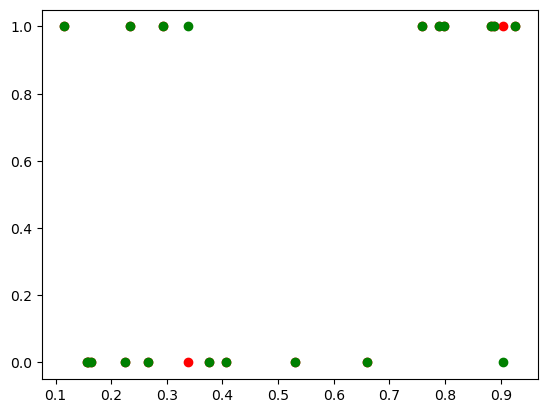

In [260]:
plt.scatter(X, pred, color="red")
plt.scatter(X, yTest, color="green")
plt.show()

In [261]:
from sklearn.model_selection import cross_val_score

In [262]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [263]:
def crossVal(classifier, num_splits):
    scores = cross_val_score(classifier, X, y, cv = num_splits)
    print("Accuracy Scores : ", scores)
    print("Mean accuracy score : ", scores.mean())

In [264]:
crossVal(xgb, 5)

Accuracy Scores :  [0.6  0.85 0.9  0.8  0.95]
Mean accuracy score :  0.8200000000000001


In [265]:
from sklearn.model_selection import RandomizedSearchCV

In [266]:
params = {
    "n_estimators" : [1000],
    "max_depth" : [3, 2, 1],
    "learning_rate" : [0.8],
    "num_parallel_tree" : [10, 11, 12, 13],
    "reg_alpha" : [0.5, 0.6, 0.7],
    "reg_lambda" : [1]
}

In [267]:
gridXGB = RandomizedSearchCV(xgb, params, n_iter=100, cv=5, n_jobs=1)

In [268]:
gridXGB.fit(xTrain, yTrain)

/home/aman/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 36 is smaller than n_iter=100. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='error',
                                           feature_types=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_r...
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           objective='binary:hinge',
                                           predictor=None, ...),
                   n_iter=100, n_jobs=1,
                   param_distributions={'learning_rate': [0.8],
                                        'max_depth': [3, 2, 1],
                                        'n_estimators': [1000],
                                        'num_parallel_tree': [10, 11, 12, 13],
                                        'reg_alpha': [0.5, 0.6, 0.7],
                                        'reg_lambda': [1]})

In [269]:
bestModel = gridXGB.best_estimator_
bestModel

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.8, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=10,
              objective='binary:hinge', predictor=None, ...)

In [270]:
bestParams = gridXGB.best_params_
bestParams

{'reg_lambda': 1,
 'reg_alpha': 0.5,
 'num_parallel_tree': 10,
 'n_estimators': 1000,
 'max_depth': 1,
 'learning_rate': 0.8}

In [271]:
yPred = bestModel.predict(xTest)

In [272]:
print(accuracy_score(yPred, yTest))

0.7


In [273]:
crossVal(bestModel, 5)

Accuracy Scores :  [0.65 0.85 0.9  0.8  0.8 ]
Mean accuracy score :  0.8


In [274]:
bestCLF = XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.8, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=10,
              objective='binary:hinge')

In [275]:
bestCLF.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.8, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=10,
              objective='binary:hinge', predictor=None, ...)

In [280]:
crossVal(bestCLF, 3)

Accuracy Scores :  [0.73529412 0.81818182 0.75757576]
Mean accuracy score :  0.7703505644682117
